<a href="https://colab.research.google.com/github/ZahraAlharz/Oxford-AI-Summer-School/blob/main/Copy_of_FasterRCNN_HW_CV_Oxford.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Implement FasterRCNN from scratch

In this assignment, you will create a dataset class for Vehicles-OpenImage dataset and implement Faster R-CNN from scratch.

##Dataset:
You will use the Vehicles-OpenImages Dataset, consisting of 627 images 416x416. Dataset can be downloaded from

https://public.roboflow.com/object-detection/vehicles-openimages/1

##Tasks:

1. Create a dataset class for the above dataset
2. Implement/Use a Backbone Network (you are allowed to use a pretrained CNN i.e., ResNet, VGG)
3. Implement Region Proposal Network (RPN)
4. Implement RoI Pooling
5. Implement the training loop for Faster R-CNN
6. Evaluate the model on the test set

In [ ]:
from IPython.display import clear_output

In [ ]:
!pip install pycocotools
clear_output()

In [ ]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
import torchvision
from torchvision.transforms import Compose, ToTensor

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="NV2XEWqNLcgMkm3iBqFp")
project = rf.workspace("roboflow-gw7yv").project("vehicles-openimages")
version = project.version(1)
dataset = version.download("coco")
clear_output()

# Create a Dataset Class for the Vehicles-OpenImages Dataset

In [ ]:
class COCODataset(Dataset):
    def __init__(self, root, annotation_file):
        self.root = root
        with open(annotation_file) as f:
            self.coco = json.load(f)
        self.images = self.coco['images']
        self.annotations = self.coco['annotations']
        self.categories = {cat['id']: cat['name'] for cat in self.coco['categories']}
        self.image_id_to_annotations = {}
        for annotation in self.annotations:
            image_id = annotation['image_id']
            if image_id not in self.image_id_to_annotations:
                self.image_id_to_annotations[image_id] = []
            self.image_id_to_annotations[image_id].append(annotation)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")
        annotations = self.image_id_to_annotations[img_info['id']]
        boxes = []
        labels = []
        for annotation in annotations:
            xmin = annotation['bbox'][0]
            ymin = annotation['bbox'][1]
            xmax = xmin + annotation['bbox'][2]
            ymax = ymin + annotation['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(annotation['category_id'])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {'labels': labels, 'boxes': boxes, 'image_id': torch.tensor([img_info['id']])}
        return ToTensor()(img), target

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

# Create dataset and dataloaders

train_dataset = COCODataset(root='Vehicles-OpenImages-1/train/', annotation_file='Vehicles-OpenImages-1/train/_annotations.coco.json')
val_dataset = COCODataset(root='Vehicles-OpenImages-1/valid/', annotation_file='Vehicles-OpenImages-1/valid/_annotations.coco.json')
test_dataset = COCODataset(root='Vehicles-OpenImages-1/test/', annotation_file='Vehicles-OpenImages-1/test/_annotations.coco.json')

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, collate_fn=collate_fn)

In [ ]:
# Example usage: Iterate over the train dataloader
# Debugging statements to check the data loader output
for images, targets in train_dataloader:
    print(f"Images batch type: {type(images)}")
    print(f"First image shape: {images[0].shape}")
    print(f"Targets batch type: {type(targets)}")
    print(f"First target type: {type(targets[0])}")
    print(f"First target keys: {targets[0].keys()}")
    break  # Only checking the first batch

Images batch type: <class 'tuple'>
First image shape: torch.Size([3, 416, 416])
Targets batch type: <class 'tuple'>
First target type: <class 'dict'>
First target keys: dict_keys(['labels', 'boxes', 'image_id'])


In [ ]:
print(f'The num of train images {len(train_dataset)}')
print(f'The num of validation images {len(val_dataset)}')
print(f'The num of test images {len(test_dataset)}')

The num of train images 878
The num of validation images 250
The num of test images 126


# Show images from the dataset

In [ ]:
from pycocotools.cocoeval import COCOeval
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import patches
import random

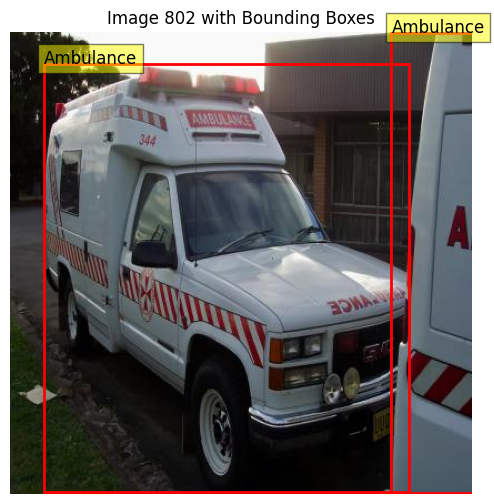

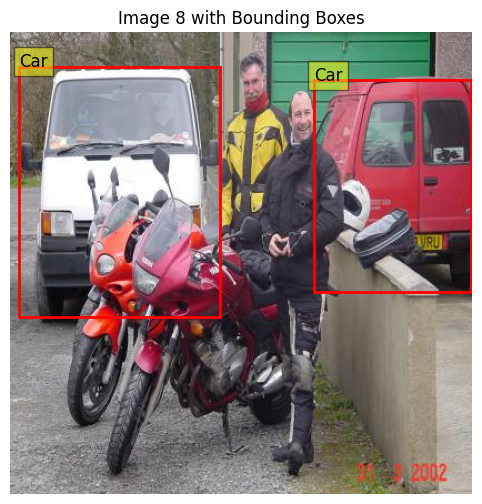

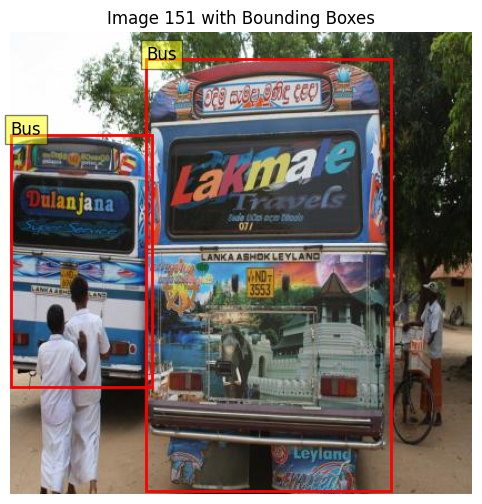

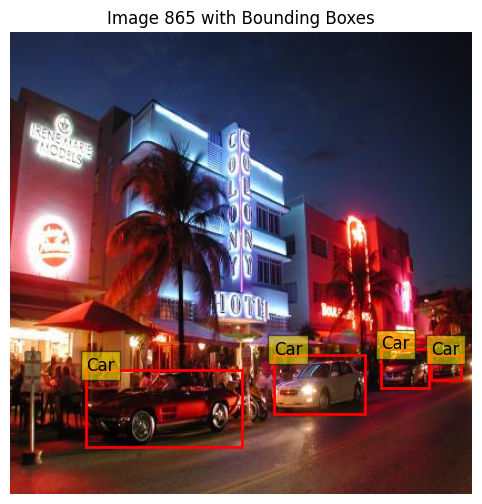

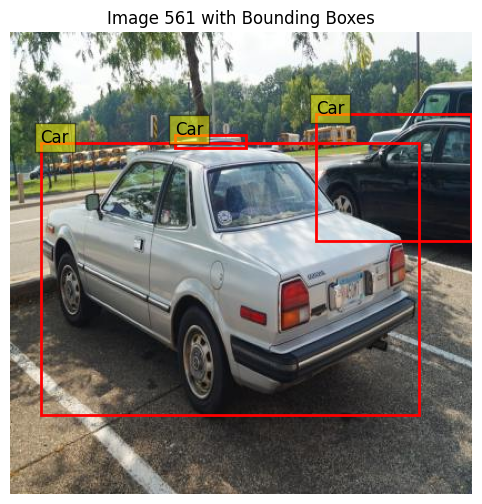

In [ ]:
# Function to display a random image with its bounding boxes and labels
def display_random_images_with_boxes(dataset, num_images=5):
    """Display random images with their bounding boxes and labels from the dataset."""
    indices = random.sample(range(len(dataset)), num_images)
    for idx in indices:
        sample = dataset[idx]
        image = sample[0].permute(1, 2, 0)  # Convert from CxHxW to HxWxC
        image_np = image.numpy()

        boxes = sample[1]['boxes'].numpy()
        labels = sample[1]['labels'].numpy()

        # Create a figure and axes
        fig, ax = plt.subplots(1, figsize=(9, 6))
        ax.imshow(image_np)

        # Draw bounding boxes and labels
        for box, label in zip(boxes, labels):
            # Extract coordinates
            x1, y1, x2, y2 = box[0], box[1], box[2], box[3]

            # Calculate width and height
            width = x2 - x1
            height = y2 - y1

            # Create a Rectangle patch
            rect = patches.Rectangle((x1, y1), width, height, linewidth=2, edgecolor='r', facecolor='none')

            # Add the patch to the Axes
            ax.add_patch(rect)

            # Add the label text
            category_name = dataset.categories[label]
            plt.text(x1, y1, category_name, fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

        # Display the image with bounding boxes
        plt.title(f'Image {idx} with Bounding Boxes')
        plt.axis('off')
        plt.show()

# Display random images with bounding boxes and labels
display_random_images_with_boxes(train_dataset, num_images=5)

# Pretrained Faster-RCNN

### Load FasterRCNN resent50 model

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load a pre-trained model and replace the head
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = len(train_dataset.categories) + 1  # +1 for the background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# Gradient clipping parameters
clip_value = 2.0
num_epochs = 8

train_loss_history = []
val_loss_history = []
train_mAP_history = []
val_mAP_history = []


### Helper function to calculate mAP

In [ ]:
# Helper function to calculate mAP
def calculate_mAP(model, dataloader, coco_gt):
    model.eval()
    coco_results = []
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        with torch.no_grad():
            outputs = model(images)
        for i, output in enumerate(outputs):
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()
            image_id = targets[i]['image_id'].item()
            for box, score, label in zip(boxes, scores, labels):
                coco_results.append({
                    'image_id': image_id,
                    'category_id': label,
                    'bbox': [box[0], box[1], box[2]-box[0], box[3]-box[1]],  # Convert to COCO format
                    'score': score
                })
    coco_dt = coco_gt.loadRes(coco_results)
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval.stats[0]  # mAP

### Train and Calculate mAP

In [ ]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, targets in train_dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        epoch_loss += losses.item()
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    train_loss_history.append(avg_epoch_loss)
    print(f"Epoch {epoch} average loss: {avg_epoch_loss}")

    # Calculate mAP for training and validation data
    train_coco = COCO('Vehicles-OpenImages-1/train/_annotations.coco.json')
    val_coco = COCO('Vehicles-OpenImages-1/valid/_annotations.coco.json')
    train_mAP = calculate_mAP(model, train_dataloader, train_coco)
    val_mAP = calculate_mAP(model, val_dataloader, val_coco)
    train_mAP_history.append(train_mAP)
    val_mAP_history.append(val_mAP)
    print(f"Epoch {epoch} training mAP: {train_mAP}")
    print(f"Epoch {epoch} validation mAP: {val_mAP}")

Epoch 0 average loss: 0.8199396122585644
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.20s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.74s).
Accumulating evaluation results...
DONE (t=0.94s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.174
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.386
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.131
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.035
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.124
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.221
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.271
 Average Recall     (

### Show mAP results

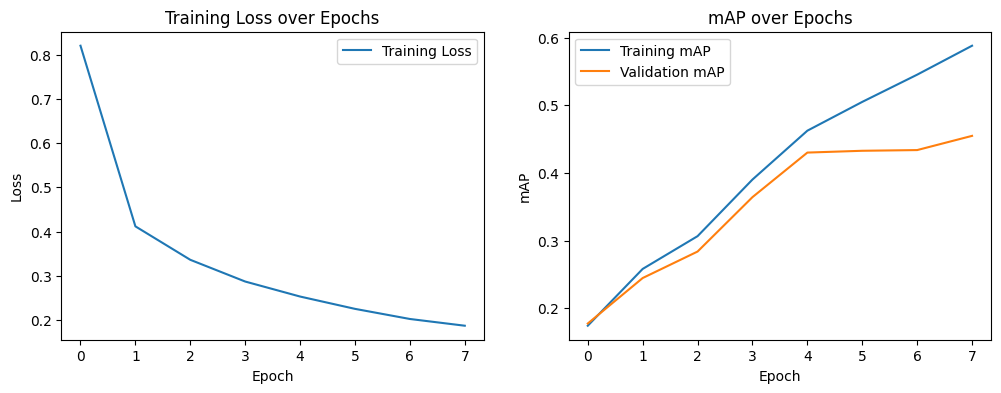

In [ ]:
# Plotting the training and validation losses and mAP
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
#plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_mAP_history, label='Training mAP')
plt.plot(val_mAP_history, label='Validation mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.title('mAP over Epochs')

plt.show()

### mAP for testing data

In [ ]:
# Predicting on the test data
test_coco = COCO('Vehicles-OpenImages-1/test/_annotations.coco.json')
test_mAP = calculate_mAP(model, test_dataloader, test_coco)
print(f"Test mAP: {test_mAP}")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.478
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.745
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.527
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.144
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.567
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.430
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.595
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

# Build Faster-RCNN from scratch

## Use a Backbone Network

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.ops import FeaturePyramidNetwork, MultiScaleRoIAlign

class ResNetBackboneWithFPN(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNetBackboneWithFPN, self).__init__()
        resnet = models.resnet50(pretrained=pretrained)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Remove the last two layers (avgpool and fc)
        self.fpn = FeaturePyramidNetwork([256, 512, 1024, 2048], 256)

    def forward(self, x):
        # Pass through resnet layers
        c2 = self.backbone[:5](x)  # Output of layer2
        c3 = self.backbone[5](c2)  # Output of layer3
        c4 = self.backbone[6](c3)  # Output of layer4
        c5 = self.backbone[7](c4)  # Output of layer5

        features = {'0': c2, '1': c3, '2': c4, '3': c5}
        fpn_features = self.fpn(features)
        return fpn_features

# Example usage:
backbone = ResNetBackboneWithFPN(pretrained=True)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 214MB/s]


In [ ]:
import torchsummary
from torchsummary import summary

## Implement Region Proposal Network (RPN)

The RPN generates region proposals. It's a small network that slides over the feature map output by the backbone network.

In [ ]:
import torchvision
from torchvision.models.detection.rpn import RegionProposalNetwork, RPNHead
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.ops import boxes as box_ops

# Define the anchor generator with sizes and aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),) * 5
)

# Create RPN head
rpn_head = RPNHead(
    in_channels=512,
    num_anchors=anchor_generator.num_anchors_per_location()[0]
)

# RPN parameters
rpn_pre_nms_top_n_train = 2000
rpn_pre_nms_top_n_test = 1000
rpn_post_nms_top_n_train = 2000
rpn_post_nms_top_n_test = 1000
rpn_nms_thresh = 0.7
rpn_fg_iou_thresh = 0.7
rpn_bg_iou_thresh = 0.3
rpn_batch_size_per_image = 256
rpn_positive_fraction = 0.5

# Instantiate RegionProposalNetwork
rpn = RegionProposalNetwork(
    anchor_generator=anchor_generator,
    head=rpn_head,
    fg_iou_thresh=rpn_fg_iou_thresh,
    bg_iou_thresh=rpn_bg_iou_thresh,
    batch_size_per_image=rpn_batch_size_per_image,
    positive_fraction=rpn_positive_fraction,
    pre_nms_top_n={'training': rpn_pre_nms_top_n_train, 'testing': rpn_pre_nms_top_n_test},
    post_nms_top_n={'training': rpn_post_nms_top_n_train, 'testing': rpn_post_nms_top_n_test},
    nms_thresh=rpn_nms_thresh
)


## ROI Align

In [ ]:
from torchvision.ops import RoIAlign

def get_roi_align(output_size=(7, 7), spatial_scale=1.0, sampling_ratio=2):
    return RoIAlign(output_size, spatial_scale, sampling_ratio)

## Faster RCNN

In [ ]:
import torch
import torch.nn as nn
from torchvision.models.detection.rpn import RegionProposalNetwork, RPNHead
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.ops import MultiScaleRoIAlign

class FasterRCNN(nn.Module):
    def __init__(self, num_classes, backbone, rpn, roi_pool, transform):
        super(FasterRCNN, self).__init__()
        self.backbone = backbone
        self.rpn = rpn
        self.roi_pool = roi_pool
        self.classifier = nn.Linear(256 * 7 * 7, num_classes)
        self.bbox_regressor = nn.Linear(256 * 7 * 7, num_classes * 4)
        self.transform = transform

    def forward(self, images, targets=None):
        images, targets = self.transform(images, targets)
        features = self.backbone(images.tensors)
        proposals, rpn_losses = self.rpn(images, features, targets)

        if targets is not None:
            rois = [proposal.to(images.tensors.device) for proposal in proposals]
            pooled_features = self.roi_pool(features, rois)
            pooled_features = pooled_features.view(pooled_features.size(0), -1)
            class_logits = self.classifier(pooled_features)
            bbox_preds = self.bbox_regressor(pooled_features)

            # Compute Fast R-CNN losses
            loss_classifier = nn.CrossEntropyLoss()(class_logits, targets['labels'])
            loss_bbox_regressor = nn.SmoothL1Loss()(bbox_preds, targets['boxes'])

            losses = {
                'loss_rpn': sum(rpn_losses.values()),
                'loss_classifier': loss_classifier,
                'loss_bbox_regressor': loss_bbox_regressor
            }

            return losses
        else:
            # For inference, implement final box processing here
            pass

# Define the transform
transform = GeneralizedRCNNTransform(
    min_size=800,
    max_size=1333,
    image_mean=[0.485, 0.456, 0.406],
    image_std=[0.229, 0.224, 0.225]
)

# Example usage:
num_classes = len(train_dataset.categories) + 1  # 6 classes + 1 for background
backbone = ResNetBackboneWithFPN(pretrained=True)

# Ensure the anchor sizes and aspect ratios match the FPN levels
anchor_generator = AnchorGenerator(
    sizes=((32,), (64,), (128,), (256,), (512,)),
    aspect_ratios=((0.5, 1.0, 2.0),) * 5  # Adjust this line to match the number of FPN levels
)

rpn_head = RPNHead(
    in_channels=256,
    num_anchors=anchor_generator.num_anchors_per_location()[0]
)

rpn = RegionProposalNetwork(
    anchor_generator=anchor_generator,
    head=rpn_head,
    fg_iou_thresh=0.7,
    bg_iou_thresh=0.3,
    batch_size_per_image=256,
    positive_fraction=0.5,
    pre_nms_top_n={'training': 2000, 'testing': 1000},
    post_nms_top_n={'training': 2000, 'testing': 1000},
    nms_thresh=0.7
)

roi_pool = MultiScaleRoIAlign(
    featmap_names=['0', '1', '2', '3'],
    output_size=7,
    sampling_ratio=2
)

faster_rcnn = FasterRCNN(num_classes, backbone, rpn, roi_pool, transform)


In [ ]:
import torch.optim as optim

# Training loop (simplified)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
faster_rcnn = faster_rcnn.to(device)
optimizer = torch.optim.SGD(faster_rcnn.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10

def train_one_epoch(model, optimizer, dataloader, device):
    model.train()
    for images, targets in dataloader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Assuming model output is a dictionary of losses
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

# Assuming train_dataloader is defined
for epoch in range(num_epochs):
    train_one_epoch(faster_rcnn, optimizer, train_dataloader, device)


AssertionError: Anchors should be Tuple[Tuple[int]] because each feature map could potentially have different sizes and aspect ratios. There needs to be a match between the number of feature maps passed and the number of sizes / aspect ratios specified.